In [1]:
! conda list coin

# packages in environment at /Users/Olivier/anaconda:
#
pybitcointools            1.1.15                    <pip>
pycoin                    0.52                      <pip>


In [2]:
import os, sys
import struct
import requests as rq
import pandas as pd
import datetime as dt

import pybitcointools as bc
import pycoin as pc
from copy import deepcopy

from IPython.display import display, Image
from ezprettyjson import prettyjson


pd.set_option('max_colwidth', 120)

##Elliptic Curve secp256k1

The elliptic curve domain parameters over $\mathbb{F}_p$ associated with the (Koblitz) elliptic curve **secp256k1** are specified by the sextuple $T = ( p, a, b, G, n, h)$ where the finite field $\mathbb{F}_p$ is defined by:

$p\ =\ FFFFFFFF\ FFFFFFFF\ FFFFFFFF\ FFFFFFFF\ FFFFFFFF\ FFFFFFFF\ FFFFFFFE\ FFFFFC2F$
$p\ =\ 2^{256}-2^{32}-2^9-2^8-2^7-2^6-2^4-1$

The curve $E:\ y^2 = x^3 + ax + b$ over $\mathbb{F}_p$ is defined by:  
$a\ =\ 0$  
$b\ =\ 7$  

The base point $G$ is:  
$G\ =\ 04$  
$\ \ \ \ \ 79BE667E\ F9DCBBAC\ 55A06295\ CE870B07\ 029BFCDB\ 2DCE28D9\  59F2815B\ 16F81798\ $
$\ \ \ \ \ 483ADA77\ 26A3C465\ 5DA4FBFC\ 0E1108A8\ FD17B448\ A6855419\ 9C47D08F\ FB10D4B8$

The base point $G$ in compressed form is:  
$G\ =\ 02\ 79BE667E\ F9DCBBAC\ 55A06295\ CE870B07\ 029BFCDB\ 2DCE28D9\ 59F2815B\ 16F81798$  

Finally the order n of G and the cofactor are:  
$n\ =\ FFFFFFFF\ FFFFFFFF\ FFFFFFFF\ FFFFFFFE\ BAAEDCE6\ AF48A03B\ BFD25E8C\ D0364141$  
$h\ =\ 1$



References:  
https://wiki.openssl.org/index.php/Elliptic_Curve_Cryptography  
http://www.secg.org/SEC2-Ver-1.0.pdf  

In [3]:
def to_hex(d):
    return '%0x' % d
    return '{:0x}'.format(d)

def compress_point(x, y):
#     if y & 1:
    if (y % 2) == 0:
        res = '03' + '%0x' % x
    else:
        res = '02' + '%0x' % x
    return res


print 'a={}'.format(bc.A)
print 'b={}'.format(bc.B)
print 'E: y^2=x^3+{}x+{}'.format(bc.A, bc.B)

print '\nP={}'.format(bc.P)
print 'P=2^256-2^32-2^9-2^8-2^7-2^6-2^4-1 ? {}'.format(bc.P==2**256-2**32-2**9-2**8-2**7-2**6-2**4-1)
print 'P~{}'.format(float(bc.P))

print '\nN={}'.format(bc.N)
print 'N~{}'.format(float(bc.N))

print '\nN*G={}'.format(bc.fast_multiply(bc.G, bc.N))
print '(N+1)*G=G ? {}'.format(bc.fast_multiply(bc.G, bc.N+1)==bc.G)

print '\nG={}'.format(bc.G)
print 'Gx={}'.format(to_hex(bc.Gx))
print 'Gx(hex)={}'.format(bc.Gx)
print 'Gy={}'.format(bc.Gy)
print 'Gy(hex)={}'.format(bc.Gy)
print 'G(compressed)={}'.format(compress_point(bc.Gx, bc.Gy))


a=0
b=7
E: y^2=x^3+0x+7

P=115792089237316195423570985008687907853269984665640564039457584007908834671663
P=2^256-2^32-2^9-2^8-2^7-2^6-2^4-1 ? True
P~1.15792089237e+77

N=115792089237316195423570985008687907852837564279074904382605163141518161494337
N~1.15792089237e+77

N*G=(0L, 0L)
(N+1)*G=G ? True

G=(55066263022277343669578718895168534326250603453777594175500187360389116729240L, 32670510020758816978083085130507043184471273380659243275938904335757337482424L)
Gx=79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798
Gx(hex)=55066263022277343669578718895168534326250603453777594175500187360389116729240
Gy=32670510020758816978083085130507043184471273380659243275938904335757337482424
Gy(hex)=32670510020758816978083085130507043184471273380659243275938904335757337482424
G(compressed)=0379be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798


##Key Generation

WIF format: https://en.bitcoin.it/wiki/Wallet_import_format


In [4]:
print '\nGenerate a random private key'
valid_private_key = False
while not valid_private_key:
    private_key_hex = bc.random_key() # returns random int from 0 to 2^256-1
    private_key_dec = bc.decode_privkey(private_key_hex, 'hex')
    valid_private_key =  0 < private_key_dec < bc.N
print 'private_key_hex =\n', private_key_hex
print 'private_key_dec =\n', private_key_dec

print '\nConvert private key to WIF format'
private_key_wif = bc.encode_privkey(private_key_dec, 'wif')
print 'private_key_wif =\n', private_key_wif

print '\nAdd suffix 01 to indicate a compressed private key'
private_key_hex_compressed = private_key_hex + '01'
print 'private_key_hex_compressed =\n', private_key_hex_compressed

print '\nGenerate a WIF format from the compressed private key (WIF-compressed)'
private_key_dec_compressed = bc.decode_privkey(private_key_hex_compressed, 'hex')
private_key_compressed__wif = bc.encode_privkey(private_key_dec_compressed, 'wif')
print 'private_key_compressed_wif =\n', private_key_compressed__wif

print '\nMultiply the EC generator point G with the private key to get a public key point'
public_key_2d = bc.fast_multiply(bc.G, private_key_dec)
print 'public_key_2d =\n', public_key_2d
print 'public_key_2d = bc.privkey_to_pubkey(private_key_dec) ? {}'.format(
    public_key_2d==bc.privkey_to_pubkey(private_key_dec))

print '\nEncode as hex, prefix 04'
public_key_hex = bc.encode_pubkey(public_key_2d, 'hex')
print 'public_key_hex =\n', public_key_hex

print '\nCompress public key, adjust prefix depending on whether y is even or odd'
(public_key_x, public_key_y) = public_key_2d
if (public_key_y % 2) == 0:
    prefix = '02'
else:
    prefix = '03'
public_key_hex_compressed = prefix + bc.encode(public_key_x, 16)
print 'public_key_hex_compressed =\n', public_key_hex_compressed

print '\nGenerate bc address from public key'
bitcoin_address_b58check = bc.pubkey_to_address(public_key_2d)
print 'bitcoin_address_b58check =\n', bitcoin_address_b58check
print 'bitcoin_address_b58check = hex_to_b58check(hash160(public_key_hex)) ? {}'.format(
    bitcoin_address_b58check==bc.hex_to_b58check(bc.hash160(public_key_hex.decode('hex'))))

print '\nGenerate compressed bc address from compressed public key'
bitcoin_address_compressed_b58check = bc.pubkey_to_address(public_key_hex_compressed)
print 'bitcoin_address_compressed_b58check =\n', bc.pubkey_to_address(bitcoin_address_compressed_b58check)


# print '----'




Generate a random private key
private_key_hex =
6c6b63e24c6e7e5cf9b3c8ace52a2fe623d536eb15d3b9cf06726f297df23952
private_key_dec =
49039529656809524709390269522489409812197945674239876627236556849815261165906

Convert private key to WIF format
private_key_wif =
5Je31eRHdEQpyZFHypv2zSQfPMKfm7aeZpYRxJqBCvJQkqn4d7v

Add suffix 01 to indicate a compressed private key
private_key_hex_compressed =
6c6b63e24c6e7e5cf9b3c8ace52a2fe623d536eb15d3b9cf06726f297df2395201

Generate a WIF format from the compressed private key (WIF-compressed)
private_key_compressed_wif =
KzrTsrACNvCAkdL5wpV5nX9SRehQ5i3Worqj97he3cFqr5MauLCm

Multiply the EC generator point G with the private key to get a public key point
public_key_2d =
(5028604712199560878288575025396070995869514280952353362560209582265556723406L, 107578099789758099658178023208178190298149830983624299227096505834153762554417L)
public_key_2d = bc.privkey_to_pubkey(private_key_dec) ? True

Encode as hex, prefix 04
public_key_hex =
040b1e16e347567fafbc

##Blockchain API
+ https://blockchain.info/
+ https://blockchain.info/api

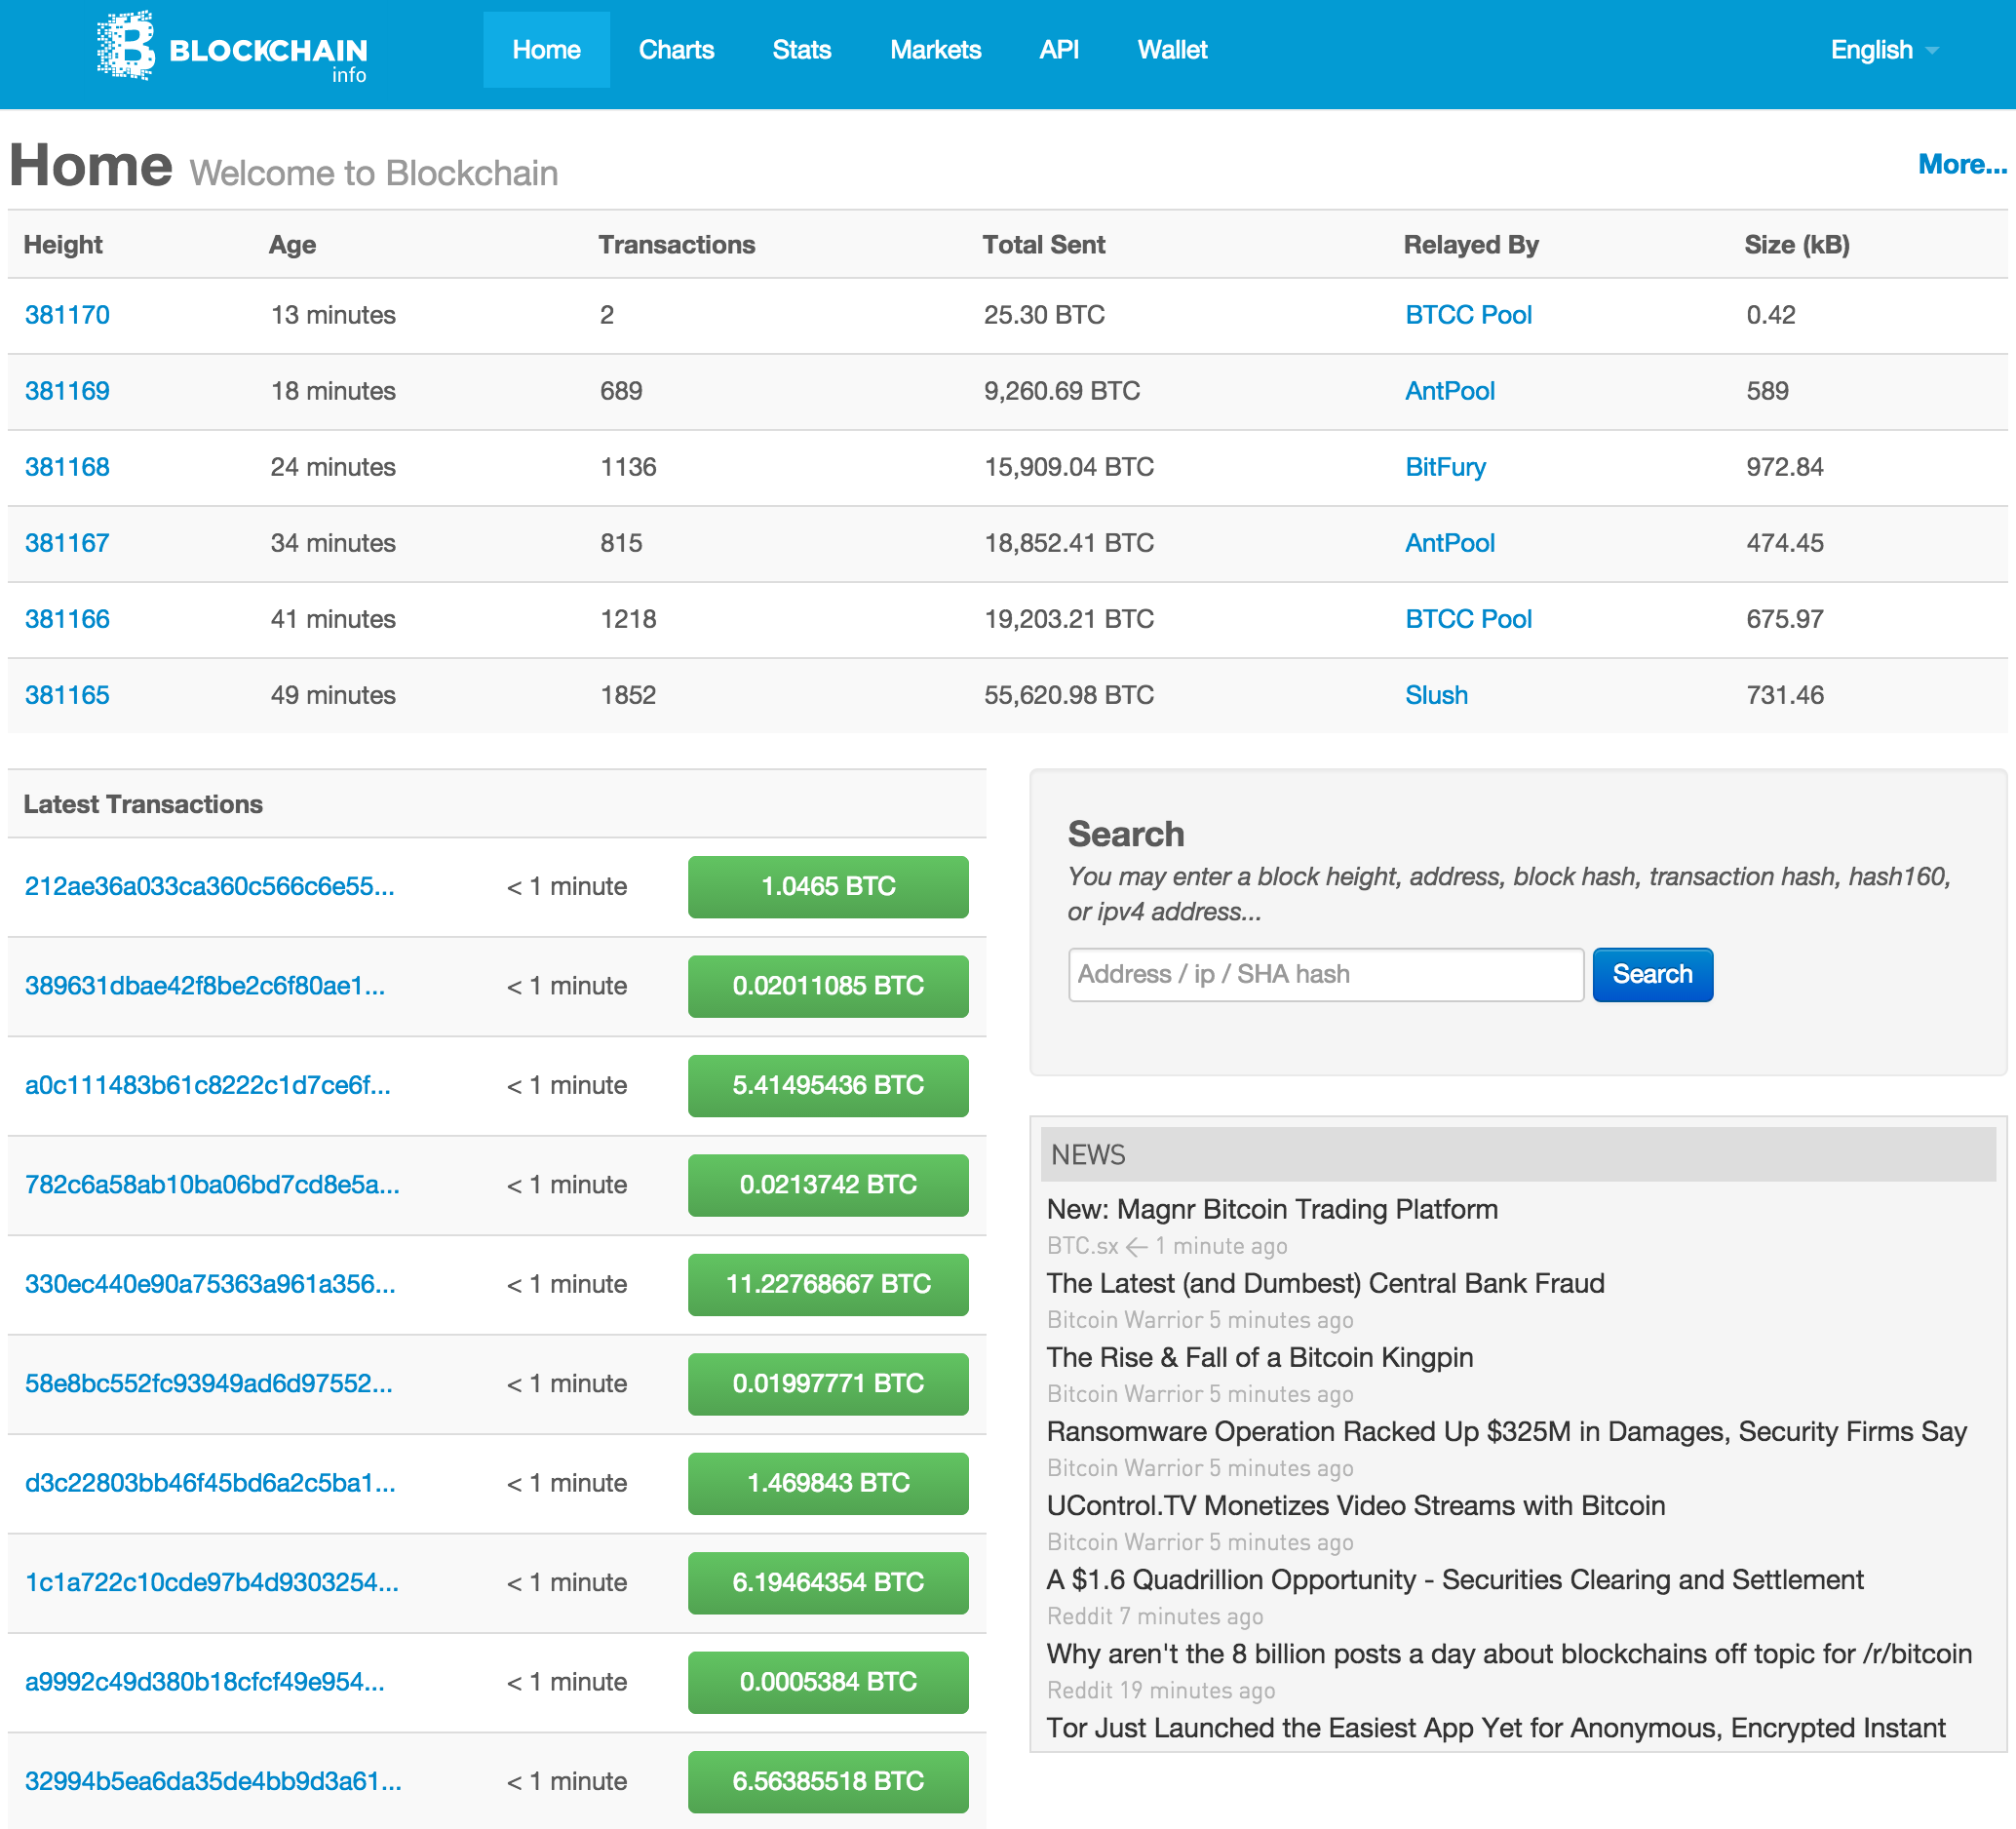

In [5]:
Image(os.path.join('data', 'Blockchain.info.png'))

##Blockchain functions
+ Blocks
+ Transactions

In [6]:
def load_raw(url):
    return rq.get(url).content


def load(url):
    response = rq.get(url)
    return response.json()


def compute_block_hash(block):
    
    def int_to_little_endian_hex(x):
        return struct.pack('<i', x).encode('hex')

    def long_to_little_endian_hex(x):
        return struct.pack('<L', x).encode('hex')

    def big_endian_hex_to_litte_endian_hex(x):
        return x.decode('hex')[::-1].encode('hex')

    header_hex =  int_to_little_endian_hex(block['ver']) + \
                        big_endian_hex_to_litte_endian_hex(block['prev_block']) + \
                        big_endian_hex_to_litte_endian_hex(block['mrkl_root']) + \
                        int_to_little_endian_hex(block['time'])+ \
                        int_to_little_endian_hex(block['bits'])+ \
                        long_to_little_endian_hex(block['nonce'])
    header_bin = header_hex.decode('hex')
    h = bc.bin_sha256(bc.bin_sha256(header_bin))[::-1].encode('hex')
    return h


def bits_to_target(bits):
    bb = '{:0x}'.format(bits)
    coef = int(bb[2:], 16)
    expo = int(bb[:2], 16)
    target = coef*2**(8*(expo-3))
    return target

target0 = bits_to_target(486604799) # first block difficulty=1

OPCODES = {106: 'OP_RETURN',
           118: 'OP_DUP',
           135: 'OP_EQUAL',
           136: 'OP_EQUALVERIFY',           
           166: 'OP_RIPEMD160 ',
           167: 'OP_SHA1 ',
           168: 'OP_SHA256 ',
           169: 'OP_HASH160',
           170: 'OP_HASH256',
           172: 'OP_CHECKSIG',
           173: 'OP_CHECKSIGVERIFY',
           174: 'OP_CHECKMULTISIG',
           175: 'OP_CHECKMULTISIGVERIFY',
          }


def convert_opcode(c):
    if c in OPCODES.keys():
        return OPCODES[c]
    else:
        return c

    
def deserialize_script(s):        
    res = bc.deserialize_script(s)
    return map(convert_opcode, res)
    
    
def overview_tx(tx, tx_no, raw=False):
    tt = tx[tx_no]
    print 'tx hash = {}'.format(tt['hash'])
    stx = load_raw('https://blockchain.info/tx-index/{}?format=hex'.format(tt['hash']))
    stt = bc.deserialize(stx)

    print 'nb inputs / outputs = {} / {}'.format(len(stt['ins']), len(stt['outs']))

    print '\n----input tx'
    for k in range(len(stt['ins'])):
        s = deserialize_script(stt['ins'][k]['script'])
        print '\nn = {}'.format(k)
        if tx_no>0:
            pk = s[1]
            from_addr = bc.pubkey_to_address(pk)
            from_addr_api = tt['inputs'][k]['prev_out']['addr']
            print 'from (manual) = {}'.format(from_addr)
            print 'from (manual) = from (API) ? {}'.format(from_addr==from_addr_api)
        print 'scriptSig =\n{}'.format(s)

    print '\n----output tx'
    for k in range(len(stt['outs'])):    
        s = deserialize_script(stt['outs'][k]['script'])
        print '\nn = {}'.format(k)
        if tx_no>0:
            h_pk = s[2]
            to_addr = bc.hex_to_b58check(h_pk)
            to_addr_api = tt['out'][k]['addr']
            print 'to (manual) = {}'.format(to_addr)
            print 'to (manual) = to (API) ? {}'.format(from_addr==from_addr_api)
        print 'scriptPubKey =\n{}'.format(s)
        
    if raw:
        print '\n----raw tx =\n{}'.format(stt)
        

##Get latest block

In [7]:
block_hash = load_raw('https://blockchain.info/q/latesthash')
print 'latest block_hash = {}'.format(block_hash)

latest block_hash = 000000000000000003fce9fffd13d351cd288aed3270a4069fd5f2896187b724


##Load block

In [8]:
block_hash = '00000000000000001e8d6829a8a21adc5d38d0a473b144b6765798e61f98bd1d' #-----testing
block = load('https://blockchain.info/rawblock/{}?format=json'.format(block_hash))
tx = block.pop('tx')
block_height = block['height']
block_index = block['block_index']
block_time = block['time']

print 'block_height = {}'.format(block_height)
print 'block_index = {}'.format(block_index)
print 'block_time = {}'.format(dt.datetime.fromtimestamp(block_time).strftime('%Y-%m-%d %H:%M:%S'))
print 'nb tx in block = {}'.format(len(tx))

block

block_height = 125552
block_index = 140402
block_time = 2011-05-21 19:26:31
nb tx in block = 4


{u'bits': 440711666,
 u'block_index': 140402,
 u'fee': 1000000,
 u'hash': u'00000000000000001e8d6829a8a21adc5d38d0a473b144b6765798e61f98bd1d',
 u'height': 125552,
 u'main_chain': True,
 u'mrkl_root': u'2b12fcf1b09288fcaff797d71e950e71ae42b91e8bdb2304758dfcffc2b620e3',
 u'n_tx': 4,
 u'nonce': 2504433986,
 u'prev_block': u'00000000000008a3a41b85b8b29ad444def299fee21793cd8b9e567eab02cd81',
 u'size': 1496,
 u'time': 1305998791,
 u'ver': 1}

##Check block hash

In [9]:
h = compute_block_hash(block)
nz = len(h)-len(h.lstrip('0'))
target = bits_to_target(block['bits'])
success_prob = target/2.0**256

print 'manual block hash = {}'.format(h)
print 'manual block hash = block hash from API ? {}'.format(h==block['hash'])
print 'nb of leading hex zeros = {}'.format(nz)
print '1/2^(4*nb_leading_zeros) = {}'.format(1.0/2**(4*nz))
print 'success proba = {}'.format(success_prob)
print 'difficulty = {}'.format(1.0*target0/target)


manual block hash = 00000000000000001e8d6829a8a21adc5d38d0a473b144b6765798e61f98bd1d
manual block hash = block hash from API ? True
nb of leading hex zeros = 16
1/2^(4*nb_leading_zeros) = 5.42101086243e-20
success proba = 9.5376968652e-16
difficulty = 244112.487774


##Coinbase transaction
+ First transaction in each block

In [10]:
tx_no = 0
print '\n\n********tx_no={} in block_height={}'.format(tx_no, block_height)
overview_tx(tx, tx_no, raw=True)




********tx_no=0 in block_height=125552
tx hash = 51d37bdd871c9e1f4d5541be67a6ab625e32028744d7d4609d0c37747b40cd2d
nb inputs / outputs = 1 / 1

----input tx

n = 0
scriptSig =
['f2b9441a', '2a01']

----output tx

n = 0
scriptPubKey =
['04d879d5ef8b70cf0a33925101b64429ad7eb370da8ad0b05c9cd60922c363a1eada85bcc2843b7378e226735048786c790b30b28438d22acfade24ef047b5f865', 'OP_CHECKSIG']

----raw tx =
{'locktime': 0, 'outs': [{'value': 5001000000, 'script': '4104d879d5ef8b70cf0a33925101b64429ad7eb370da8ad0b05c9cd60922c363a1eada85bcc2843b7378e226735048786c790b30b28438d22acfade24ef047b5f865ac'}], 'version': 1, 'ins': [{'script': '04f2b9441a022a01', 'outpoint': {'index': 4294967295, 'hash': '0000000000000000000000000000000000000000000000000000000000000000'}, 'sequence': 4294967295}]}


##Regular transactions
+ Any transaction after the coinbase tx

In [11]:
for tx_no in range(1, min(6, len(tx))):
    print '\n\n********tx_no={} in block_height={}'.format(tx_no, block_height)
    overview_tx(tx, tx_no)




********tx_no=1 in block_height=125552
tx hash = 60c25dda8d41f8d3d7d5c6249e2ea1b05a25bf7ae2ad6d904b512b31f997e1a1
nb inputs / outputs = 1 / 2

----input tx

n = 0
from (manual) = 1HuppjXz7dPrt2a67LqacDW5T4VanFrpqC
from (manual) = from (API) ? True
scriptSig =
['30460221009805aa00cb6f80ca984584d4ca40f637fc948e3dbe159ea5c4eb6941bf4eb763022100e1cc0852d3f6eb87839edca1f90169088ed3502d8cde2f495840acac69eefc9801', '0486477e6a23cb25c9a99f0c467c6fc86197e718ebfd41d1aef7cc3cbd75197c1f1aaba985b22b366a0729ccb8aa38277809d6d218cf4077ac9f29a953b5435222']

----output tx

n = 0
to (manual) = 1B8vkT58i8KUPVJvvyQfrbc8Wjwu3vEarQ
to (manual) = to (API) ? True
scriptPubKey =
['OP_DUP', 'OP_HASH160', '6f31097e564b9d54ebad662d5c4b5621c18ff523', 'OP_EQUALVERIFY', 'OP_CHECKSIG']

n = 1
to (manual) = 1BQbxzgRSLEsmv1JNc8MG76wdUgMwbsaww
to (manual) = to (API) ? True
scriptPubKey =
['OP_DUP', 'OP_HASH160', '7228033b48b380900501c39c61da4ab453ca88e8', 'OP_EQUALVERIFY', 'OP_CHECKSIG']


********tx_no=2 in block_heigh

##Transaction fees
+ Sum input tx values minus sum output tx values

In [12]:
li_in_val, li_out_val = [], []

for tx_no in range(len(tx)):
    tt = tx[tx_no]
    in_val = sum([e['prev_out']['value'] for e in tt['inputs'] if 'prev_out' in e])
    out_val = sum([e['value'] for e in tt['out']])
    li_in_val.append(in_val)
    li_out_val.append(out_val)

df_tf = pd.DataFrame({'Sum(in)': li_in_val, 'Sum(out)': li_out_val, 'tx_no': range(len(tx))}).set_index('tx_no')
df_tf.columns.name = 'BlockHeigh={}'.format(block_height)
df_tf['Fee'] = df_tf['Sum(in)']-df_tf['Sum(out)']
df_tf.ix[0, 'Fee'] = 0 # mining
    
print 'Transaction fees = {} BTC for block_height={}'.format(round(df_tf['Fee'].sum()/1.0e8, 8), block_height)
    
df_tf

Transaction fees = 0.01 BTC for block_height=125552


BlockHeigh=125552,Sum(in),Sum(out),Fee
tx_no,,,
0,0,5001000000,0
1,2950000000,2950000000,0
2,487000000,486000000,1000000
3,15000000,15000000,0


##Verify Transaction signature
###Simple tx only

Signing a tx could be circular. Indeed how to sign a transaction, which by definition contains the signature, before you created that signature ??  

In order to solve this paradox, a modified temporary version of the transaction is created only for the purpose of creating the signature. A modified transaction is created for each input as follows:  
+ Copy the transaction to sign  
+ For all inputs but the one to sign, set the script to an empty string.
+ For the input you wan to sign, set its script to the outpoint transaction script, the outpoint transaction script being the ScriptPubKey of the transaction which the current input claims.  

This process is performed below on all inputs of a transaction.


In [13]:
def check_tx_inputs_signature(tx_hash, show=False):
    tx = load_raw('https://blockchain.info/tx-index/{}?format=hex'.format(tx_hash))
    tx_json = bc.deserialize(tx)

    if show:
        print 'tx hash = {}'.format(tx_hash)
        print '\nraw tx\n= {}'.format(tx)
        print '\njson tx\n= {}'.format(tx_json)

    print '\nnb inputs = {}'.format(len(tx_json['ins']))
    for i in range(len(tx_json['ins'])):
        print 'input {}:\t'.format(i), 
        sig, pk = deserialize_script(tx_json['ins'][i]['script'])
        prev_hash = tx_json['ins'][i]['outpoint']['hash']
        prev_idx = tx_json['ins'][i]['outpoint']['index']
        prev_tx = load_raw('https://blockchain.info/tx-index/{}?format=hex'.format(prev_hash))
        prev_tx_json = bc.deserialize(prev_tx) 
        out_script = prev_tx_json['outs'][prev_idx]['script']

        tx_mod = deepcopy(tx_json)
        for k, e in enumerate(tx_json['ins']):
            if k!=i:
                tx_mod['ins'][k]['script'] = ''
            else:
                tx_mod['ins'][k]['script'] = out_script
        tx_mod_hex = bc.serialize(tx_mod)

        print 'signature ok ? {}'.format(bc.ecdsa_tx_verify(tx_mod_hex, sig, pk))

        
tx_hash = 'bfe6daa8b0c6a7e702e877e4b1284ec7b2683613205de946f459649640341993'
check_tx_inputs_signature(tx_hash, show=True)

tx hash = bfe6daa8b0c6a7e702e877e4b1284ec7b2683613205de946f459649640341993

raw tx
= 0100000003ea5d5888f85804e02a7d3f35c3065ad47abcfdf67516152d2baa49833cc3271b000000006b483045022100d803468b8cf1562c8e71f9c357e1173b79cb2bca20d931c80cba37293f8bc9480220139986e89ec3af9ac69cc6d7fbb7917e24f4c700fe14121b83e2aa01788d52f0012103fe44e9ea58122851c3e9b91541570bdd0ec25218fe186bb31ebadc7b0ba6b01bfeffffff7e66c38f8f5b74bc08d5b2d7d2081d55b7ad44fed06995d05f918a0d3dea2fda010000006b483045022100d5d7fd1f0b48434072fbf9be08389dfdb776a4567654d14ef5c5c289d7a51a5b0220054edf472501e8c67153148561b69aa25edf8d4e9a1e9ffca7a8fa8ac20934e3012102ca3a71f52f1efe901d7777d28f166cabb29d381561af2f543110bcab8000c35bfeffffffe3e05778c566453df71848648c4b940f8a288def4ca834cebc1514bf767f0cf9000000006a473044022012fbd6e7ff79aad165c022c0e909f1142d2e711a85675dddd5ebdf3df4f3f5090220143b6e1efff159ccd557402b41a07cc1e350808bcf5226db534f453c71bc2f050121035ae49b64e582205df0a6cf5dfbd6e3524dbdea87acadab2abb06763c454b6f93feffffff012e592701000000001